In [24]:
!pip install requests --upgrade
!pip install bs4 --upgrade
!pip install datetime --upgrade
!pip install pandas --upgrade
!pip install matplotlib --upgrade
# import nltk
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [1]:
import requests 
from bs4 import BeautifulSoup
import datetime

In [2]:
#Find top 100 movies in a specific year
def movie_from_year(year):

    if year< 1980 or year> int(str(datetime.datetime.now())[:4]):
        raise ValueError('Please input time during 1980 till now.')
    url = 'https://www.boxofficemojo.com/yearly/chart/?yr='+str(year)+'&p=.htm'
    response = requests.get(url)
    results = BeautifulSoup(response.content, 'lxml')
    results = results.find_all('a')        
    
    url_list=[]
    name_list = []
    for result in results:
        if result.get('href') != None:
            if 'id='in result.get('href') and '#' not in result.get_text():
                url_list.append('https://www.boxofficemojo.com'+result.get('href'))
                name_list.append(result.get_text())
    return url_list,name_list

In [3]:
#Find movie urls and names from one year to the other
def find_from_to(yearx,yeary):

    import pandas as pd
    
    list_all_url = []
    list_all_name = []
    
    for year in range(yearx,yeary+1):
        url,name = movie_from_year(year)
        list_all_url.extend(url)
        list_all_name.extend(name)
    


    return {list_all_name[i]:list_all_url[i] for i in range(len(list_all_url))}
find_from_to(2018,2018)

{'Black Panther': 'https://www.boxofficemojo.com/movies/?id=marvel2017b.htm',
 'Avengers: Infinity War': 'https://www.boxofficemojo.com/movies/?id=marvel0518.htm',
 'Incredibles 2': 'https://www.boxofficemojo.com/movies/?id=theincredibles2.htm',
 'Jurassic World: Fallen Kingdom': 'https://www.boxofficemojo.com/movies/?id=jurassicworldsequel.htm',
 'Deadpool 2': 'https://www.boxofficemojo.com/movies/?id=foxmarvel18.htm',
 'Mission: Impossible - Fallout': 'https://www.boxofficemojo.com/movies/?id=missionimpossible6.htm',
 'Ant-Man and the Wasp': 'https://www.boxofficemojo.com/movies/?id=ant-manandthewasp.htm',
 'Solo: A Star Wars Story': 'https://www.boxofficemojo.com/movies/?id=untitledhansolostarwarsanthologyfilm.htm',
 'Venom (2018)': 'https://www.boxofficemojo.com/movies/?id=venom2018.htm',
 'A Star is Born (2018)': 'https://www.boxofficemojo.com/movies/?id=astarisborn2018.htm',
 'A Quiet Place': 'https://www.boxofficemojo.com/movies/?id=aquietplace.htm',
 "Dr. Seuss' The Grinch (201

In [20]:
#  a specifi movie's daily gross
def gross_movie(name,begin_year=1980,end_year=2018):      
    import pandas as pd
    import requests 
    from bs4 import BeautifulSoup
    try:
        movie_url = find_from_to(begin_year,end_year)[name]
        id_position = movie_url.find('id=')
        name_id = movie_url[id_position:]
        url = 'https://www.boxofficemojo.com/movies/?page=daily&view=chart&'+name_id
        response = requests.get(url)
        results = BeautifulSoup(response.content, 'lxml')
        tables = results.select('table')
        df_list = []
        for table in tables:
            df_list.append(pd.concat(pd.read_html(table.prettify())))
        movie_gross = df_list[7]
        movie_gross.columns = ['Day','Date','Rank','Gross','%daily-change','%weekly-change','Theaters','Average','Gross-to-Date','Days']
        movie_gross = movie_gross[(movie_gross['Date'] != 'Date') & (movie_gross['Date'].notnull())]
        movie_gross.set_index('Date',inplace=True)
        movie_gross[['Days']] = movie_gross[['Days']].astype(int)
        return movie_gross        
    except:
        ValueError(f'{name} is not in the TOP100 of year from to {begin_year} to {end_year}')

In [30]:
 # a specifi movie's basic information
def data_movie(name,begin_year=1980,end_year=2018):      
    import pandas as pd
    import requests 
    from bs4 import BeautifulSoup
    try:
        movie_url = find_from_to(begin_year,end_year)[name]
        response = requests.get(movie_url)
        results = BeautifulSoup(response.content, 'lxml')
        tables = results.select('table')
        df_list = []
        for table in tables:
            df_list.append(pd.concat(pd.read_html(table.prettify())))
        movie_info = {}
        movie_info['Name'] = name
        
        movie_info['Genre'] = df_list[5][0].iloc[2][8:]
        movie_info['Runtime'] = df_list[5][1].iloc[2][10:]
        movie_info['Production Budget'] = df_list[5][1].iloc[3][20:]
        
        movie_info['Domestic Gross'] = df_list[9][1].iloc[0]
        try:
            movie_info['Foreign Gross'] = df_list[9][1].iloc[1]
        except:
            movie_info['Foreign Gross'] = None
        try:
            movie_info['Worldwide Gross'] = df_list[9][1].iloc[3]
        except:
            movie_info['Worldwide Gross'] = None
        
        movie_info['Release Date'] = df_list[5][1].iloc[1][15:]
    
        for n in [12,13,14,15,16]:
            if df_list[n][0].iloc[0] == 'In Release:':      
                movie_info['Inrelease Time'] = df_list[n][1].iloc[0]
                df_list[n+1].set_index(0,inplace=True)
                
                try:
                    movie_info['Actors'] = df_list[n+1][1].loc['Actors:']
                except:
                    movie_info['Actors'] = None
                
                try:
                    movie_info['Director'] = df_list[n+1][1].loc['Director:']
                except:
                    movie_info['Director'] = None   
                
                try:
                    movie_info['Producer'] = df_list[n+1][1].loc['Producer:']
                except:
                    movie_info['Producer'] = None   
                
                break
            else:
                n = n + 1
   
        movie_info['Distributor'] = df_list[5][0].iloc[1][14:]
        
        mv = pd.DataFrame(list(movie_info.items()))
        mv.columns = ['Items',name]
        mv.set_index('Items',inplace=True)
#         mv.to_csv(path_or_buf=f'./{name}Basic_info.csv')
        mv
        return mv
    except:
        ValueError(f'{name} is not in the TOP100 of year from to {begin_year} to {end_year}')

In [ ]:
#df_list[5] = Distributor, Genre,MPAA Rating,Release Date,Runtime,Production Budget
#df_list[9] = gross Domestic Foreign Worldwide
#df_list[10] = opening weekend, opending weekend of total gross
#df_list[11] = widest release of theaters
#df_list[12] = close date
#df_list[13] = inrelease time period
#df_list[14] = Director, Actors, Producer, Cinematographer, Composer

In [31]:
def data_movies_table(begin_year=1980,end_year=2018,input_name=None):  
    if not input_name == None:
        name_list = input_name
    else:
        name_list = list(find_from_to(begin_year,end_year).keys())
    movie_table = data_movie(name_list[0],begin_year,end_year)
    for name in name_list[1:]:
        try:
            movie_info = data_movie(name,begin_year,end_year)
            movie_table[name]=movie_info[name]
        except:
            continue

#     mv.to_csv(path_or_buf=f'./{begin_year}-{end_year}some movies basic info.csv')
    return movie_table.T 

In [32]:
data_movies_table(2018,2018)

Items,Name,Genre,Runtime,Production Budget,Domestic Gross,Foreign Gross,Worldwide Gross,Distributor
Black Panther,Black Panther,Action / Adventure,2 hrs. 20 min.,N/A,"$700,059,566","$646,853,595","$1,346,913,161",Buena Vista
Incredibles 2,Incredibles 2,Animation,1 hrs. 58 min.,N/A,"$608,516,446","$632,328,436","$1,240,844,882",Buena Vista
Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,Action / Adventure,2 hrs. 8 min.,$170 million,"$416,769,345","$888,174,715","$1,304,944,060",Universal
Deadpool 2,Deadpool 2,Action,1 hrs. 59 min.,$110 million,"$318,491,426","$415,754,495","$734,245,921",Fox
Mission: Impossible - Fallout,Mission: Impossible - Fallout,Action,2 hrs. 27 min.,$178 million,"$220,159,104","$570,858,348","$791,017,452",Paramount
Ant-Man and the Wasp,Ant-Man and the Wasp,Action,1 hrs. 58 min.,N/A,"$216,648,740","$405,957,488","$622,606,228",Buena Vista
Solo: A Star Wars Story,Solo: A Star Wars Story,Action / Adventure,2 hrs. 15 min.,N/A,"$213,767,512","$179,157,295","$392,924,807",Buena Vista
A Star is Born (2018),A Star is Born (2018),Music Drama,2 hrs. 16 min.,$36 million,"$191,711,990","$165,100,000","$356,811,990",Warner Bros.
A Quiet Place,A Quiet Place,Horror Thriller,1 hrs. 35 min.,$17 million,"$188,024,361","$152,652,838","$340,677,199",Paramount
Dr. Seuss' The Grinch (2018),Dr. Seuss' The Grinch (2018),Animation,1 hrs. 30 min.,$75 million,"$184,673,105","$35,900,000","$220,573,105",Universal


In [44]:
# We want to do some analysis about moives' feature distribution and trend over time.
# Since a trend often requires a long time, which takes a long timeto see the result with the above function, 
# therefore,we turn to another function to download the movie data, which is faster but includes fewer features.

# Find a movie's data with a provided url
def movie_data(url):
    from bs4 import BeautifulSoup
    import pandas as pd
    import numpy as np
    import requests
    response=requests.get(url)
    result = BeautifulSoup(response.content,'lxml')
    name = ['Name','Domestic Total Gross','Distributor','Release Time','Genre','Runtime','MPAA Rating','Production Budget','Worldwide Gross']
    data_list = [item.get_text() for item in result.find_all('b')[1:9]]
    data_list.append(result.find_all('b')[13].get_text())
    if 'Domestic Lifetime Gross:' in data_list[2]:
        data_list = [item.get_text() for item in result.find_all('b')[1:3]]
        new_list = [item.get_text() for item in result.find_all('b')[4:10]]
        data_list.extend(new_list)
        data_list.append(result.find_all('b')[14].get_text())
    if '$' not in data_list[-1]:
        data_list[-1] = 'N/A'
    a = pd.DataFrame(data_list,name)
    b = np.transpose(a)
    b.set_index('Name', inplace = True)
    return b

#Find top 100 movies' data
def movie_data_group(year):   
    import pandas as pd
    url_list,name_list = movie_from_year(year)
    list_ = []
    for url in url_list:
        try:
            a = movie_data(url)
        except:
            continue
        list_.append(a)
    try:
        return pd.concat(list_)
    except:
        return 'No data'

In [45]:
movie_2016 = movie_data_group(2016)

In [46]:
movie_2016

,Domestic Total Gross,Distributor,Release Time,Genre,Runtime,MPAA Rating,Production Budget,Worldwide Gross
Name,,,,,,,,
Rogue One:A Star Wars Story,"$532,177,324",Buena Vista,"December 16, 2016",Sci-Fi Adventure,2 hrs. 13 min.,PG-13,$200 million,"$1,056,057,273"
Finding Dory,"$486,295,561",Buena Vista,"June 17, 2016",Animation,1 hrs. 43 min.,PG,N/A,"$1,028,570,889"
Captain America:Civil War,"$408,084,349",Buena Vista,"May 6, 2016",Action / Adventure,2 hrs. 27 min.,PG-13,$250 million,"$1,153,304,495"
The Secret Life of Pets,"$368,384,330",Universal,"July 8, 2016",Animation,1 hrs. 30 min.,PG,$75 million,"$875,457,937"
The Jungle Book (2016),"$364,001,123",Buena Vista,"April 15, 2016",Adventure,1 hrs. 45 min.,PG,$175 million,"$966,550,600"
Deadpool,"$363,070,709",Fox,"February 12, 2016",Action,1 hrs. 46 min.,R,$58 million,"$783,112,979"
Zootopia,"$341,268,248",Buena Vista,"March 4, 2016",Animation,1 hrs. 48 min.,PG,N/A,"$1,023,784,195"
Batman v Superman:Dawn of Justice,"$330,360,194",Warner Bros.,"March 25, 2016",Action / Adventure,2 hrs. 31 min.,PG-13,$250 million,"$873,634,919"
Suicide Squad,"$325,100,054",Warner Bros.,"August 5, 2016",Action / Adventure,2 hrs. 10 min.,PG-13,$175 million,"$746,846,894"


In [57]:
#This function is used to draw a pie graph for the feature distributions in top 100 movies.
def pie_graph(data,feature):
    
    import pandas as pd
    import numpy as np  
    import matplotlib.pyplot as plt 
    new_data = data.groupby(feature).size().sort_values(ascending = False)
    label = list(new_data.index)
    x = list(new_data)
    abc = [(label[i],x[i]) for i in range(len(label))]
    ab = abc[:5]
    new_label = [item[0] for item in ab]
    new_x = [item[1] for item in ab]
    new_label.append('Others')
    total = [item[1] for item in abc]
    new_x.append(sum(total)-sum(new_x))
    fig = plt.figure()
    plt.axes(aspect=1)
    plt.pie(new_x,labels=new_label,autopct='%1.2f%%',shadow= True) 
    plt.title(feature.capitalize()+" Distribution")
    plt.show()

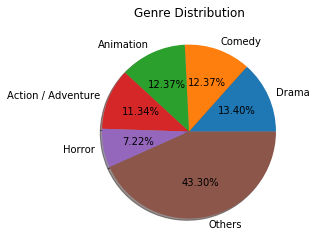

In [58]:
pie_graph(movie_2016,'Genre')

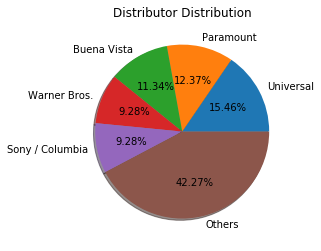

In [60]:
pie_graph(movie_2016,'Distributor')

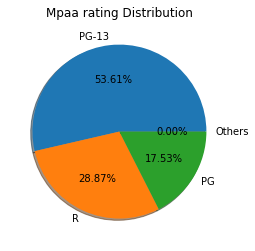

In [63]:
pie_graph(movie_2016,'MPAA Rating')

In [ ]:
#This function is used to see the trend of a specific genre in top 100 movies from a given year to a gieven year.
def movie_genre_trend(data,start_year, genres):
    import numpy as np
    import matplotlib.pyplot as plt
    year_list = list(range(len(data)))
    new_list = [year+start_year for year in year_list]
    for genre in genres:
        count = []
        for item in data:
            try:
                count.append(item.groupby('Genre').size()[genre])
            except:
                count.append(0)
        plt.plot(new_list,count,label=genre)
        plt.title('Movie Trend')
        plt.legend()

In [65]:
data_total =[]
for i in range(2010,2019):
    data_total.append(movie_data_group(i))
    

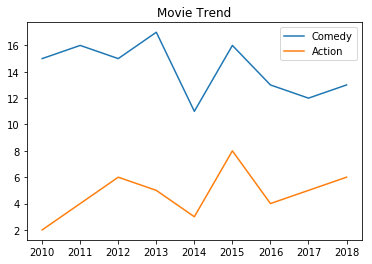

In [68]:
movie_genre_trend(data_total,2010,['Comedy','Action'] )

In [10]:
def get_review(name, page_length = 2, num = 20):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://www.rottentomatoes.com/m/'+name+'/reviews/'
    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    results = results_page.find_all('div', class_ = 'the_review')
    page = 1
    reviews = list()
    next_page_results = list()

    while page < page_length:
        for item in results_page.find_all('a', class_ = 'btn btn-xs btn-primary-rt'):
            if item.find('span', class_ = "glyphicon glyphicon-chevron-right"):
                url = 'https://www.rottentomatoes.com' + item.get('href')
        response = requests.get(url)
        results_page = BeautifulSoup(response.content, 'lxml')
        next_page_results = results_page.find_all('div', class_ = 'the_review')
        results.extend(next_page_results)
        page+=1
    for result in results:
        reviews.append(result.get_text())

    return reviews[:num]

In [11]:
def get_name_review(year, num = 30, page_length = 2, length = 20):
    movies = list(find_from_to(year,year).keys())
    for i in range(len(movies)):
        movies[i] = movies[i].lower().replace(' ', '_').replace(':', '').replace(',', '_').replace('.', '_').replace("'", '').replace('!', '_').replace('?', '').replace('-', '_').replace('(', '').replace(')', '').replace('_a_new_dragon_tattoo_story','').replace('the_equalizer_2','equalizer_2').replace('dr__seuss_the_grinch_2018','the_grinch').replace('disneys_','')
        movies[i] = movies[i].lower().replace('___', '_')
        movies[i] = movies[i].lower().replace('__', '_')
    review_list = list()
    name_list = list(find_from_to(year,year).keys())[:num]
    for movie in movies[:num]:
        review = get_review(movie, page_length, length)
        if not review or len(review)<5:
            try:
                review = get_review(movie+f'_{year}', page_length, length)
            except:
                print('Do not find the movie')
        
        review_list.append(' '.join(review))
    name_review = list(zip(name_list, review_list))
    return name_review

name_review = get_name_review(2018)

In [12]:
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

In [25]:
def do_pos_neg_sentiment_analysis(reviews):
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    for review in reviews:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(review[1]):
            if word in positive_words:
                cpos+=1
            if word in negative_words:
                cneg+=1
        results.append((review[0],cpos/len(word_tokenize(review[1])),cneg/len(word_tokenize(review[1]))))
        
    import pandas as pd    
    df_simple = pd.DataFrame(results, columns = ['name', 'positive', 'negative'])
    df_simple.set_index('name', inplace = True)
    df_simple.sort_values(by = 'positive', ascending = False, inplace = True)
    
    return df_simple
do_pos_neg_sentiment_analysis(name_review)

,positive,negative
name,,
Black Panther,0.076923,0.014652
Ralph Breaks the Internet,0.076271,0.019068
Ready Player One,0.072089,0.038817
Mission: Impossible - Fallout,0.070652,0.018116
Mamma Mia! Here We Go Again,0.070213,0.023404
Solo: A Star Wars Story,0.069597,0.029304
Crazy Rich Asians,0.069498,0.021236
I Can Only Imagine,0.069098,0.013436
Incredibles 2,0.068519,0.003704


In [17]:
def get_nrc_data():
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count=0
    emotion_dict=dict()
    with open(nrc,'r') as fp:
        lines = list()
        for line in fp:
            if count < 46:
                count+=1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict
emotion_dict = get_nrc_data()

In [18]:
def comparative_emotion_analyzer(reviews,object_name="Movie"):
    def emotion_analyzer(review,emotion_dict=emotion_dict):
        emotions = {x for y in emotion_dict.values() for x in y}
        emotion_count = dict()
        for emotion in emotions:
            emotion_count[emotion] = 0

        total_words = len(review.split())
        for word in review.split():
            if emotion_dict.get(word):
                for emotion in emotion_dict.get(word):
                    emotion_count[emotion] += 1/len(review.split())
        return emotion_count

    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
      
    for review in reviews:
        result = emotion_analyzer(review[1])
        df.loc[review[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
        
    df['All_positive'] = df['Trust'] + df['Positive'] + df['Joy'] + df['Anticipation'] + df['Surprise']
    df['All_negative'] = df['Negative'] +df['Disgust'] +df['Sadness']
    df.sort_values('All_positive', ascending = False, inplace = True)
    
    return df
        
comparative_emotion_analyzer(name_review)

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise,All_positive,All_negative
Movie,,,,,,,,,,,
Mamma Mia! Here We Go Again,0.007500,0.025000,0.020000,0.045000,0.042500,0.002500,0.057500,0.017500,0.017500,0.187500,0.040000
I Can Only Imagine,0.013363,0.037862,0.013363,0.066815,0.033408,0.004454,0.033408,0.022272,0.015590,0.187082,0.040089
Ralph Breaks the Internet,0.005025,0.032663,0.017588,0.047739,0.035176,0.002513,0.030151,0.002513,0.020101,0.165829,0.022613
Hotel Transylvania 3: Summer Vacation,0.017199,0.024570,0.039312,0.056511,0.039312,0.004914,0.034398,0.007371,0.009828,0.164619,0.051597
Peter Rabbit,0.012712,0.025424,0.016949,0.057203,0.033898,0.006356,0.031780,0.010593,0.012712,0.161017,0.033898
Ocean's 8,0.008351,0.027140,0.020877,0.052192,0.033403,0.002088,0.033403,0.008351,0.012526,0.158664,0.031315
Rampage (2018),0.025806,0.027957,0.027957,0.058065,0.027957,0.004301,0.034409,0.006452,0.006452,0.154839,0.038710
Solo: A Star Wars Story,0.014737,0.021053,0.025263,0.054737,0.031579,0.006316,0.035789,0.012632,0.010526,0.153684,0.044211
Incredibles 2,0.008493,0.021231,0.012739,0.059448,0.025478,0.000000,0.031847,0.008493,0.010616,0.148620,0.021231


In [ ]:
# There are some details need to be adjusted
# get_movie_urls: the first item is wrong
# data_movies_table: something is wrong when handling with lots of items
